In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import arviz as az
from makeCorner import *
import sys
sys.path.append("./../code/")
from piCurve import *
from load_data import *

For this run, we assume that the stochastic gravitational-wave background is possibly polarized, such that the expectation value of the cross-correlation statistic is

$$
\begin{aligned}
C(f) &= \gamma_R(f)\, \Omega^R(f) + \gamma_L(f)\, \Omega^L(f) \\[5pt]
    &= \gamma_R(f)\, \Omega^R_0 \left(\frac{f}{f_0}\right)^{\alpha_R} + \gamma_L(f)\, \Omega^L_0 \left(\frac{f}{f_0}\right)^{\alpha_L},
\end{aligned}
$$

with a reference frequency of $f_0 = 25\,\mathrm{Hz}$.
We've assumed that both R/L polarizations are independently described as power laws. 

Note that the cross-correlation statistic reported in LVK data releases is normalized as $Y(f) = C(f)/\gamma_I(f)$, where $\gamma_I(f) = \gamma_R(f) + \gamma_L(f)$ is the "ordinary" overlap reduction function for an unpolarized background.
So the signal model appearing in our code is actually 

$$
Y(f) = \frac{\gamma_R(f)}{\gamma_I(f)}\, \Omega^R_0 \left(\frac{f}{f_0}\right)^{\alpha_R} + \frac{\gamma_L(f)}{\gamma_I(f)}\, \Omega^L_0 \left(\frac{f}{f_0}\right)^{\alpha_L}.
$$

A key for parameter names appearing below

| Name      | Description |
| :---------- | :---------- |
| `alpha_L`     | The spectral index on the left-circularly polarized gravitational-wave background |
| `alpha_R`     | The spectral index on the right-circularly polarized gravitational-wave background |
| `log_Omega_L` | Log10 of the reference amplitude of the left-circularly polarized background |
| `log_Omega_R` | Log10 of the reference amplitude of the right-circularly polarized background |

First, load chains and print some summary statistics:

In [3]:
data = az.from_netcdf('right_left.cdf')
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_L,-0.707,3.079,-6.260,4.803,0.077,0.061,1632.0,1668.0,1.00
alpha_R,-0.765,3.122,-6.413,5.242,0.092,0.065,1152.0,1368.0,1.00
log_Omega_L,-10.400,1.535,-12.977,-7.942,0.047,0.034,925.0,598.0,1.00
log_Omega_R,-10.479,1.529,-12.965,-7.972,0.045,0.033,1036.0,833.0,1.01
logit_log_Omega_L,-0.995,1.265,-3.229,0.939,0.050,0.043,925.0,598.0,1.00
logit_log_Omega_R,-1.049,1.246,-3.410,0.896,0.044,0.035,1036.0,833.0,1.01


Plot chains:

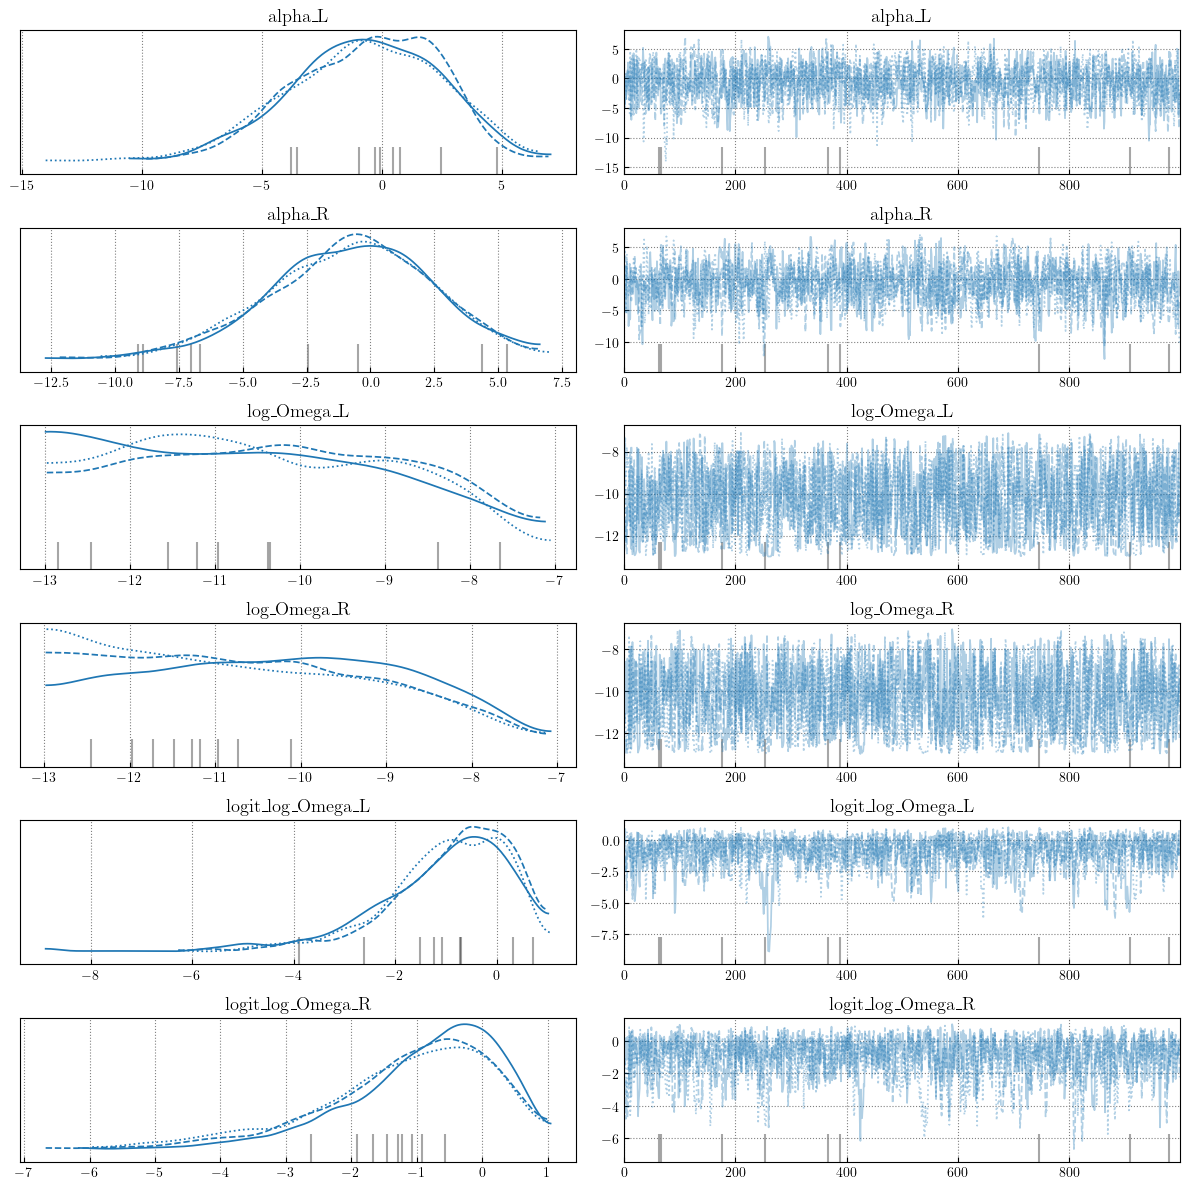

In [4]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

And a corner plot:

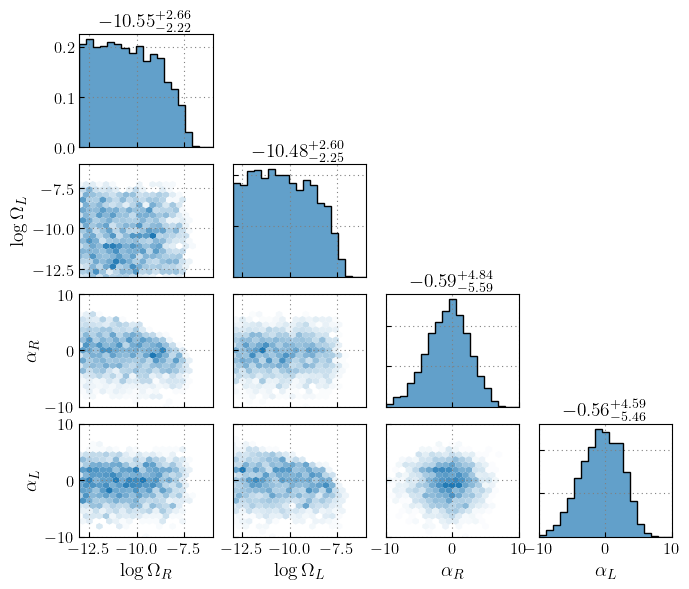

In [5]:
stacked_samples = data.posterior.stack(draws=("chain", "draw"))

fig = plt.figure(figsize=(7,6))
toPlot = {
    "OmgR":{"data":stacked_samples.log_Omega_R,"plot_bounds":(-13,-6),"label":r"$\log\Omega_R$"},
    "OmgL":{"data":stacked_samples.log_Omega_L,"plot_bounds":(-13,-6),"label":r"$\log\Omega_L$"},
    "alphaR":{"data":stacked_samples.alpha_R,"plot_bounds":(-10,10),"label":r"$\alpha_R$"},
    "alphaL":{"data":stacked_samples.alpha_L,"plot_bounds":(-10,10),"label":r"$\alpha_L$"}
}
plot_corner(fig,toPlot,'#1f78b4')
plt.tight_layout()
plt.subplots_adjust(hspace=0.15,wspace=0.15)
plt.show()

(array([1024.,  166.,  117.,   90.,   98.,   94.,   88.,  136.,  194.,
         993.]),
 array([-9.99995787e-01, -7.99996917e-01, -5.99998046e-01, -3.99999176e-01,
        -2.00000306e-01, -1.43571224e-06,  1.99997435e-01,  3.99996305e-01,
         5.99995175e-01,  7.99994045e-01,  9.99992916e-01]),
 <BarContainer object of 10 artists>)

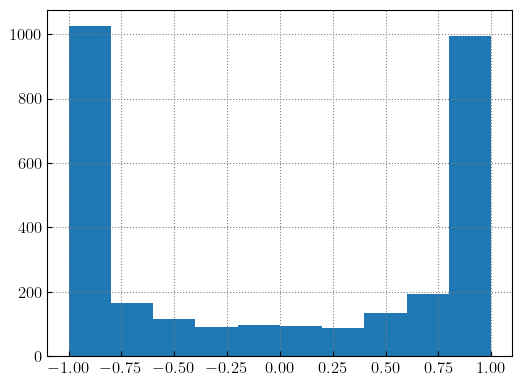

In [9]:
OmgI = 10.**stacked_samples.log_Omega_R+10.**stacked_samples.log_Omega_L
OmgV = 10.**stacked_samples.log_Omega_R-10.**stacked_samples.log_Omega_L

plt.hist(OmgV/OmgI)